In [30]:
# Import necessary libraries

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import interpolate

import math

In [133]:
# param
Temp = np.array([-40, 20, 80, 160]) #°C températures utilisé pour les simulations des aimants et bobines
Npp = 5
Imax = 20
Umax = 24 #alim 24V - pertes?
Nsp = 102
Nsp_auto = 1 # 1: Yes, 0: No, auto: utilise le nombre minimum de spires pour atteindre le couple requis

cr = 3/4 # facteur de passage R1coil - Rmoteur, 3/4: double etoile foc

# Condition de simulation
Cas = ["Froid", "Ambiant", "Chaud"]
Temp_aimants = [-40, 20, 110] # Température des aimants
Temp_bobines = [-40, 20, 160] # Température du bobinage

Couple_min_cond = 0.5 #Nm
N_max_cond = 5E+3 # rpm

couleur = ["b","y","r"]

file_name = "TEXT" # pour la différenciation lors de l'enregistrement

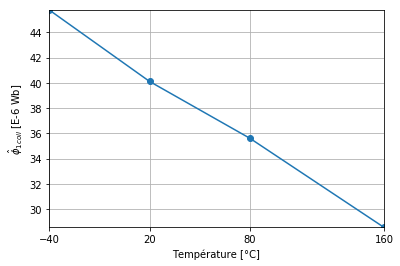

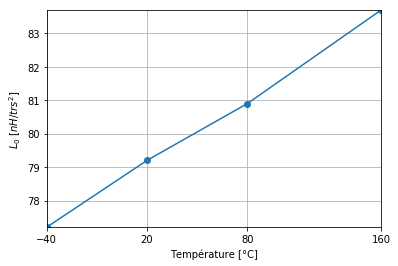

In [134]:
# Flux
phi = np.array([45.78, 40.11, 35.60, 28.55])*1E-6 #[-40, 20, 80, 160]°C

Lq0 = np.array([77.2, 79.2, 80.9, 83.7])*1E-9 # inductances 0 spires

plt.plot(Temp,phi*1E+6,'o-')
plt.xlabel("Température [°C]")
plt.ylabel("$\hat{\phi}_{1coil}$ [E-6 Wb]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(phi),max(phi)])*1E+6)
plt.xticks(Temp)
#plt.legend(loc="best")
plt.grid()
#plt.savefig("Phi_motor"+".pdf")
plt.show()

plt.plot(Temp,Lq0*1E+9,'o-')
plt.xlabel("Température [°C]")
plt.ylabel("$L_0$ [$n H/trs^2$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(Lq0),max(Lq0)])*1E+9)
plt.xticks(Temp)
#plt.legend(loc="best")
plt.grid()
#plt.savefig("Phi_motor"+".pdf")
plt.show()

R0: [3.963e-05 5.186e-05 6.409e-05 8.039e-05] 
R:  [0.412 0.54  0.667 0.836]


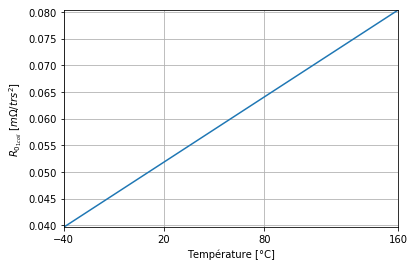

In [135]:
#Resistance
w = 4.4E-3 # tenir compte du corps de bobine
h = 24.55E-3
th = 4.75E-3
l = 9E-3
sigma = 0.565

rho = 1.72E-8*(1 + (Temp-20)*0.00393)# [-40, 20, 80, 160]°C
    
R0 = rho*(2*(w+h)+math.pi*th)/(sigma*th*l)
R = R0*Nsp**2

print("R0:",R0.round(8),"\nR: ",R.round(3))

plt.plot(Temp,R0*1E+3)
plt.xlabel("Température [°C]")
plt.ylabel("$R_{0_{1coil}}$ [$m\Omega$/$trs^2$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(R0),max(R0)])*1E+3)
plt.xticks(Temp)
plt.grid()
#plt.savefig("R0.pdf")
plt.show()

[4.578000e-05 4.011000e-05 3.295625e-05]


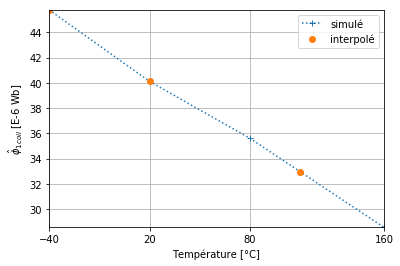

[7.720e-08 7.920e-08 8.195e-08]


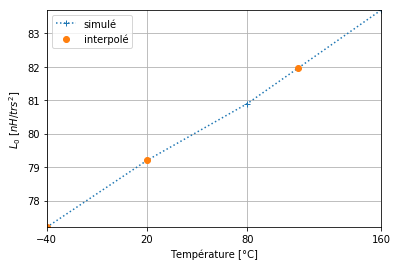

[3.96293442e-05 5.18572942e-05 8.03891775e-05]


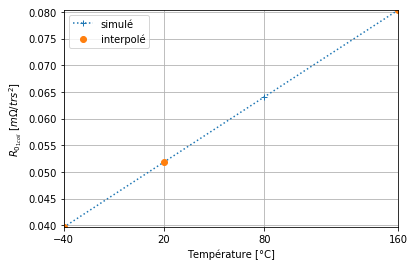

Gamma 1 coil: [0.0002289  0.00020055 0.00016478] Nm/Atrs


In [136]:
# Calcul des phi, L, R0 pour les cas définis.

# phi
intp_phi = interpolate.interp1d(Temp, phi, fill_value = "extrapolate")
phi_c  = intp_phi(Temp_aimants)

print(phi_c)

plt.plot(Temp,phi*1E+6,":+", label= "simulé")
plt.plot(Temp_aimants,phi_c*1E+6,"o", label= "interpolé")

plt.xlabel("Température [°C]")
plt.ylabel("$\hat{\phi}_{1coil}$ [E-6 Wb]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(phi),max(phi)])*1E+6)
plt.xticks(Temp)
plt.grid()
plt.legend(loc="best")
plt.show()

# Lq
intp_Lq0 = interpolate.interp1d(Temp, Lq0, fill_value = "extrapolate")
Lq0_c  = intp_Lq0(Temp_aimants)

print(Lq0_c)

plt.plot(Temp,Lq0*1E+9,":+", label= "simulé")
plt.plot(Temp_aimants,Lq0_c*1E+9,"o", label= "interpolé")

plt.xlabel("Température [°C]")
plt.ylabel("$L_0$ [$n H/trs^2$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(Lq0),max(Lq0)])*1E+9)
plt.xticks(Temp)
plt.grid()
plt.legend(loc="best")
plt.show()

# R0
intp_R0 = interpolate.interp1d(Temp, R0, fill_value = "extrapolate")
R0_c  = intp_R0(Temp_bobines)

print(R0_c)

plt.plot(Temp,R0*1E+3,":+", label= "simulé")
plt.plot(Temp_bobines,R0_c*1E+3,"o", label= "interpolé")

plt.xlabel("Température [°C]")
plt.ylabel("$R_{0_{1coil}}$ [$m\Omega$/$trs^2$]")
plt.xlim([min(Temp),max(Temp)])
plt.ylim(np.array([min(R0),max(R0)])*1E+3)
plt.xticks(Temp)
plt.grid()
plt.legend(loc="best")
plt.show()

print("Gamma 1 coil:",(Npp*phi_c),"Nm/Atrs")

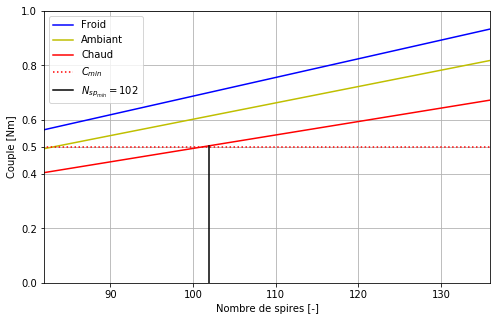

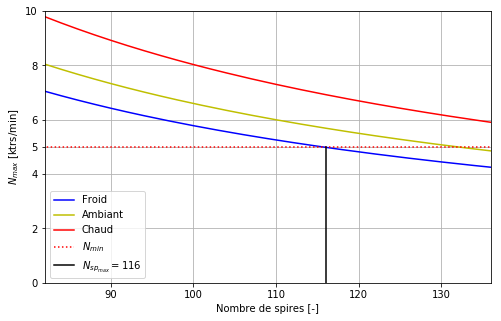

In [137]:
# Determination du nombre de spires

Nsp_array = np.array(range(1,200))

T = [] # Torque
N = [] # Max_speed
plt.figure("T",figsize=(8,5)) # torque plot
plt.figure("N",figsize=(8,5)) # speed plot
for i, cas_elem in enumerate(Cas):
    T.append(3/2*Nsp_array*Npp*phi_c[i]*Imax) # Torque formula
    N.append(30*Umax/(np.sqrt(3)*Nsp_array*Npp*phi_c[i]*math.pi)) # Max speed formula
    
    plt.figure("T") # switch plot
    plt.plot(Nsp_array,T[i], color=couleur[i], label=cas_elem)

    plt.figure("N") # switch plot
    plt.plot(Nsp_array,N[i]/1E+3,color=couleur[i],label=cas_elem)

#plot settings for torque
plt.figure("T")
plt.plot(Nsp_array,np.ones((len(Nsp_array),1))*0.5,"r:",label="$C_{min}$")

Nsp_min_pos = np.argmax(T[-1]>Couple_min_cond)
Nsp_max_pos = np.argmax(N[0]<N_max_cond)

plt.plot([Nsp_array[Nsp_min_pos], Nsp_array[Nsp_min_pos]],[0, T[-1][Nsp_min_pos]],"k",label="$N_{sp_{min}}=%i$"%(Nsp_array[Nsp_min_pos]))

plt.xlim([max(1,Nsp_array[Nsp_min_pos]-20),Nsp_array[Nsp_max_pos]+20])
plt.ylim(bottom=0,top=1)
#plt.xticks(list(plt.xticks()[0])+[Nsp_array[Nsp_min_pos]])
plt.yticks(list(plt.yticks()[0])+[Couple_min_cond])
plt.xlabel("Nombre de spires [-]")
plt.ylabel("Couple [Nm]")

plt.legend(loc="best")
plt.grid()
#plt.savefig("Nsp_torque.pdf")

# Plot settings for max speed
plt.figure("N")
plt.plot(Nsp_array,np.ones((len(Nsp_array),1))*N_max_cond/1E+3,"r:",label="$N_{min}$")

Nsp_max_pos = np.argmax(N[0]<N_max_cond)
plt.plot([Nsp_array[Nsp_max_pos], Nsp_array[Nsp_max_pos]],[0, N[0][Nsp_max_pos]/1E+3],"k",label="$N_{sp_{max}}=%i$"%(Nsp_array[Nsp_max_pos]))

plt.xlim([max(1,Nsp_array[Nsp_min_pos]-20), Nsp_array[Nsp_max_pos]+20])
plt.ylim(bottom=0,top = 10)
#plt.xticks(list(plt.xticks()[0])+[Nsp_array[Nsp_max_pos]])
plt.yticks(list(plt.yticks()[0])+[N_max_cond/1E+3])
plt.xlabel("Nombre de spires [-]")
plt.ylabel("$N_{max}$ [ktrs/min]")

plt.legend(loc="lower left")
plt.grid()
#plt.savefig("Nsp_speed.pdf")
plt.show()


if (Nsp_auto == 1): Nsp = Nsp_array[Nsp_min_pos] # reglage auto

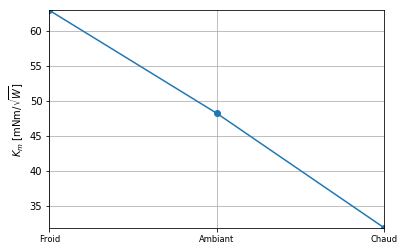

Km [Nm/sqrt(W)]:  [0.063  0.0482 0.0318]


In [138]:
# Km
Km = np.sqrt(3)*phi_c*Npp/np.sqrt(R0_c)

plt.plot(Km*1E+3,'o-')

#plt.xlabel("Température")
plt.ylabel("$K_m$ [mNm/$\sqrt{W}$]")
plt.xlim([0,len(Cas)-1])
plt.xticks(range(len(Cas)), Cas, size='small')
plt.ylim(np.array([min(Km),max(Km)])*1E+3)
plt.grid()
#plt.savefig("Km_motor"+".pdf")
plt.show()

print("Km [Nm/sqrt(W)]: ", Km.round(4))

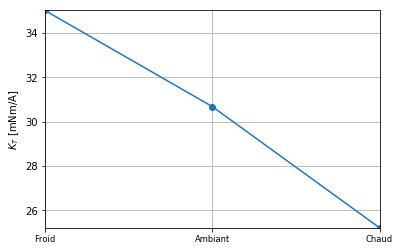

In [139]:
# Kt température

KT = 3/2*Npp*Nsp*phi_c
plt.plot(KT*1E+3,'o-')

#plt.xlabel("Cas")
plt.ylabel("$K_T$ [mNm/A]")

plt.xlim([0,len(Cas)-1])
plt.xticks(range(len(Cas)), Cas, size='small')
plt.ylim(np.array([min(KT),max(KT)])*1E+3)
plt.grid()
#plt.savefig("Kt_motor_temp"+".pdf")
plt.show()

In [140]:
def N_speed (I,R01coil,L0,phi1coil):
    R = 3/4*Nsp**2*R01coil
    L = L0*Nsp**2
    
    ke = np.sqrt(3)*Nsp*Npp*phi1coil
    
    part_a = (Umax*ke)**2+((L*I*Npp)**2)*(Umax**2-(R*I)**2)
    part_b = ke**2+(L*I*Npp)**2
    
    N = (30/np.pi)*(np.sqrt(part_a)-R*I*ke)/part_b
    
    return N

In [149]:
def Pertes (I, N, R01coil):
    # pertes fer M270-50A
    Cp = 2.52
    k = 1.5 # 1.5-1.6
    fel = N/60*Npp
    Bmax = 1.5 # PAS JUSTE 
    mfer = 0.160 # kg
    
    # pertes fer
    Pfer = np.array(Cp*(fel/50)**k*(Bmax/1.5)**2*mfer)
    
    # pertes Joules
    Pj = np.array(cr*(R01coil*(Nsp**2))*I**2)
    
    return Pfer+Pj

N_imax:  [2180. 2090. 1780.] 
N_max: [5670. 6470. 7870.]


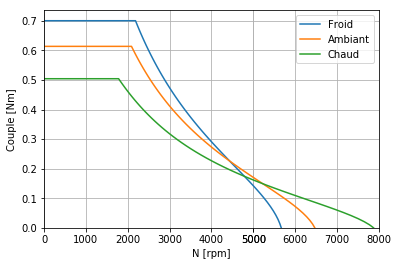

In [150]:
# Courbe T-w

I = np.linspace(Imax,0,50)

N_imax = [] # max speed with max current
N_max = [] # max speed
N_lim = [] # speed
T_lim = [] # max torque

for i, cas_elem in enumerate(Cas):
    N_imax.append(N_speed(Imax,R0_c[i],Lq0_c[i],phi_c[i])) 
    N_max.append(N_speed(0,R0_c[i],Lq0_c[i],phi_c[i]))

    N_lim.append([0,N_imax[i]] + list(N_speed(I,R0_c[i],Lq0_c[i],phi_c[i])))
    T_lim.append(list(np.array([Imax,Imax])*KT[i]) + list(I*KT[i]))

    plt.plot(N_lim[i],T_lim[i], label=cas_elem)

plt.xlim([0,max(N_max)])
plt.ylim(bottom=0)
plt.xticks(list(plt.xticks()[0])+[N_max_cond])
plt.xlabel("N [rpm]")
plt.ylabel("Couple [Nm]")

plt.legend(loc="best")
plt.grid()
#plt.savefig("Tw_%s_temp.pdf"%(file_name[i]))
print("N_imax: ",np.array(N_imax).round(-1),"\nN_max:",np.array(N_max).round(-1))
plt.show()

Rendement max Froid: 83.9
Rendement max Ambiant: 80.3
Rendement max Chaud: 73.7


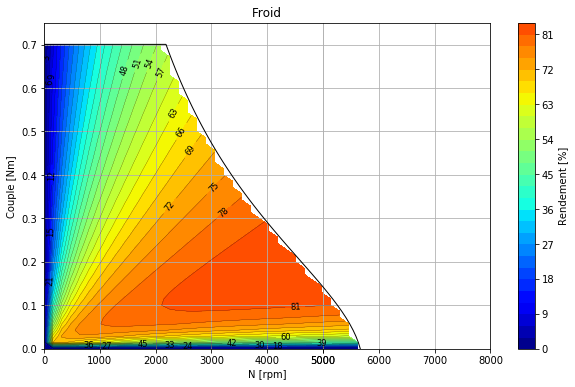

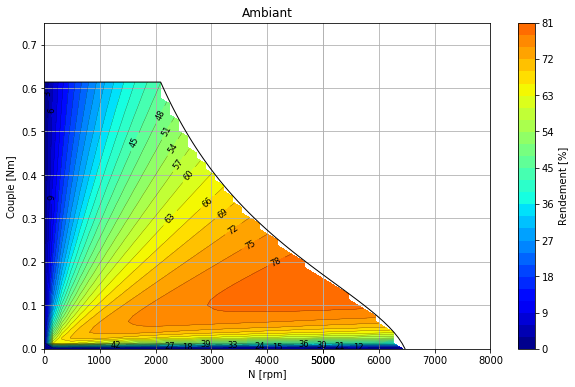

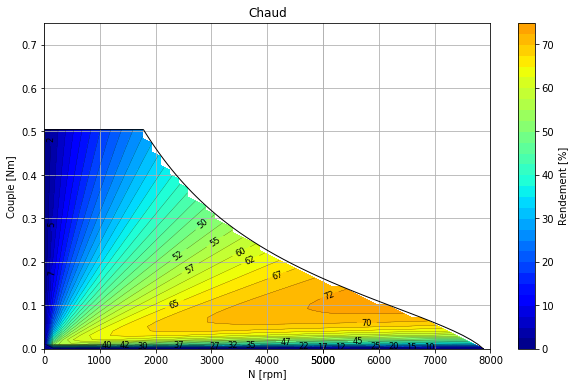

In [151]:
# T-w rendement
n_elem = 50
n_colors = 30

N = np.linspace(0,max(N_max),n_elem)
I = np.linspace(0,Imax,n_elem)


NN, II  = np.meshgrid(N,I)
PPertes = [] # puissance pertes 
PPmec = [] # puissance mec
nn = [] # rendement

for i, cas_elem in enumerate(Cas):
    plt.figure(cas_elem, figsize=(10,6))
    PPertes.append(Pertes(II,NN, R0_c[i])+1E-6)
    PPmec.append(KT[i]*II*NN/30*np.pi)

    nn.append(PPmec[i]/(PPmec[i]+PPertes[i])*100)

    # Remove all non existing points
    for i_I, row in enumerate(II):
        for i_N, elem in enumerate(row):
            if N[i_N]>N_speed(I[i_I],R0_c[i],Lq0_c[i],phi_c[i]):
                nn[i][i_I][i_N] = np.nan
                PPmec[i][i_I][i_N] = np.nan
                PPertes[i][i_I][i_N] = np.nan

    # Plot
    cs = plt.contour(NN,KT[i]*II,nn[i], n_colors, linewidths=0.2, colors="k", vmin=0, vmax=100)
    plt.contourf(NN,KT[i]*II,nn[i],n_colors, cmap = "jet", vmin=0, vmax=100)

    plt.plot(N_lim[i],T_lim[i],"k",linewidth=1)
    print("Rendement max %s: %1.1f"%(cas_elem, np.nanmax(nn[i])))

    plt.xlabel("N [rpm]")
    plt.ylabel("Couple [Nm]")
    plt.title(cas_elem)
    plt.ylim([0, max(KT)*Imax+0.05])
    plt.xticks(list(plt.xticks()[0])+[N_max_cond])
    plt.grid()
    plt.colorbar(label="Rendement [%]")
    plt.clabel(cs, fmt = "%i", fontsize = "smaller")
    #plt.savefig("Tw_rendement_%s_%iC.pdf"%(file_name[i],t_elem))
plt.show()

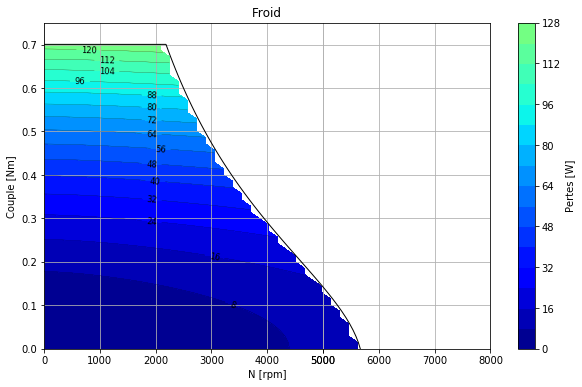

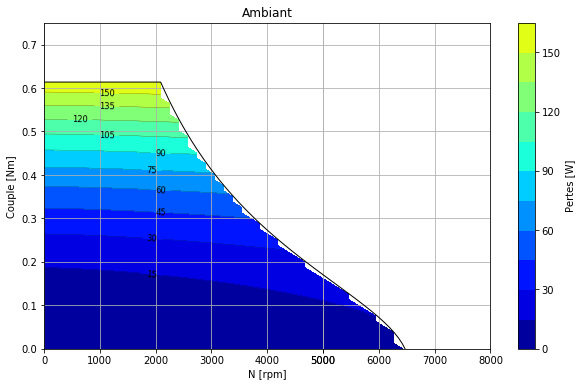

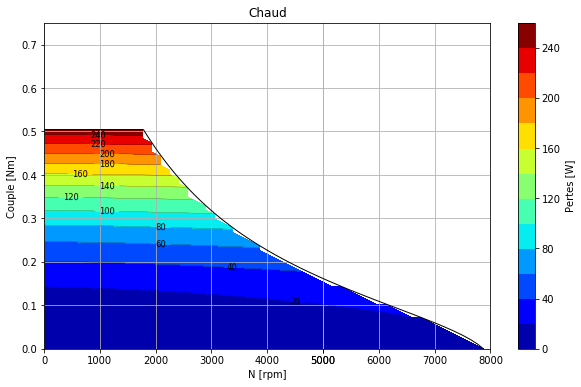

In [152]:
#T-w pertes

n_colors = 15

for i, cas_elem in enumerate(Cas):
    # Plot
    plt.figure(figsize=(10,6))

    cs = plt.contour(NN,KT[i]*II,PPertes[i], n_colors, linewidths=0.2, colors="k", vmin=0, vmax=np.nanmax(PPertes))
    plt.contourf(NN,KT[i]*II,PPertes[i],n_colors, cmap = "jet", vmin=0, vmax=np.nanmax(PPertes))
    plt.plot(N_lim[i],T_lim[i],"k",linewidth=1)

    plt.xlabel("N [rpm]")
    plt.ylabel("Couple [Nm]")
    plt.xticks(list(plt.xticks()[0])+[N_max_cond])
    plt.title(cas_elem)
    plt.ylim([0, max(KT)*Imax+0.05])
    plt.grid()
    plt.colorbar(label="Pertes [W]")
    plt.clabel(cs, fmt = "%i", fontsize = "smaller")
    #plt.savefig("Tw_pertes_%s_%iC.pdf"%(file_name[i],t_elem))    
    plt.show()